In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
import logging
import os

sns.set_theme(style="darkgrid")

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

In [189]:
!pip install statsmodels

# ОИАД. Лабораторная работа №3

Для построения моделей: datasets/insurance_train.csv
Для оценки обобщающей способности: datasets/insurance_test.csv

Инфо о датасете: https://www.kaggle.com/datasets/mosapabdelghany/medical-insurance-cost-dataset

In [190]:
!pip install kagglehub kaggle

In [191]:
!kaggle datasets download 'mosapabdelghany/medical-insurance-cost-dataset'

Dataset URL: https://www.kaggle.com/datasets/mosapabdelghany/medical-insurance-cost-dataset
License(s): CC0-1.0
medical-insurance-cost-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [192]:
if not os.path.exists("insurance.csv"):
    import zipfile
    with zipfile.ZipFile("medical-insurance-cost-dataset.zip", 'r') as zip_ref:
        zip_ref.extractall(".")

assert os.path.exists("insurance.csv")

In [193]:
df = pd.read_csv('insurance.csv')
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010



## 1. Подготовка данных
1. проверить наличие пропусков и выбросов
2. привести категориальные признаки к числовым
3. вычислить парные корреляции признаков


In [194]:
print(df.head())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


Нужно будет преобразовать: sex, region, smoker

In [195]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


In [196]:
print(df.describe())

               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


In [197]:
df.duplicated().sum()


np.int64(1)

In [198]:
df = df.drop_duplicates()

In [199]:
df.isna().sum().sum()

np.int64(0)

преобразовать: sex, region, smoker

In [200]:
df["sex"] = df["sex"].map({"female": 1, "male": 0})
df["smoker"] = df["smoker"].map({"yes": 1, "no": 0})

**ВАЖНО drop_first=True**

In [201]:
df = pd.get_dummies(df, columns=["region"], drop_first=True, dtype=int)

In [202]:
df_selected = df[["sex", "smoker"]].join(df.filter(regex="^region_"))
df_selected.head()

,sex,smoker,region_northwest,region_southeast,region_southwest
0,1,1,0,0,1
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,1,0,0
4,0,0,1,0,0


<Axes: >

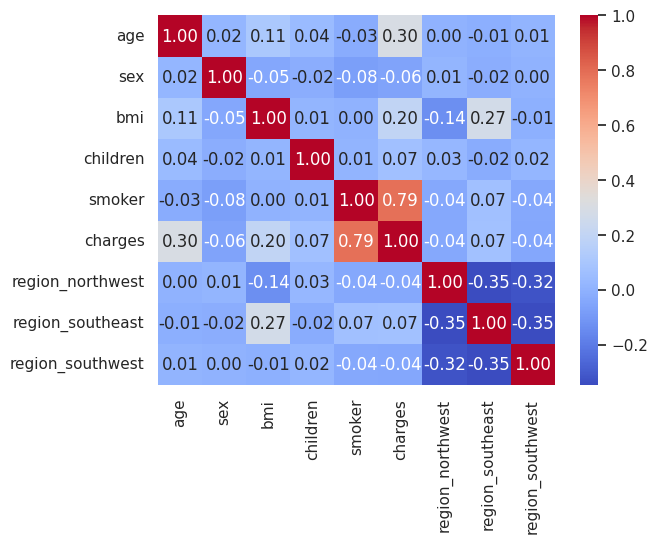

In [203]:
corr_mtx = df.corr()
sns.heatmap(corr_mtx, annot=True, fmt=".2f", cmap="coolwarm")

## 2. Многомерная линейная регрессия
Построить модель линейной регрессии и подобрать параметры:
1. аналитически (реализовать самому)
2. численно, с помощью методов градиентного спуска (реализовать самому)



**Аналитическое решение**
Для поиска точки минимума, приравниваем градиент к нулю.
$$
2X^T(Xw-y) = 0
$$

$$
X^TXw = X^Ty
$$

$$
w^* = (X^TX)^{-1}X^Ty
$$

*В каких случаях могут возникнуть проблемы с решением?*

## 3. Добавление регуляризации
Модифицировать линейную модель путем добавления регуляризационного слагаемого. Найти оптимальные веса:
1. аналитически
2. численно




**Гребневая регрессия**
$$
Q_{L_2}(w) = ||Xw - y||^2 + \alpha ||w||_2^2 \rightarrow \min_{w}
$$

$$
||a||_2 = \sqrt{\sum_{i=1}^{n} a_i^2}
$$

Имеет аналитическое решение
$$
w^* = (X^TX + \alpha I)^{-1}X^Ty
$$
где $I$ - единичная матрица

Градиент
$$
\frac{\partial Q_{L_2}}{\partial w} = 2 X^T (Xw - y) + 2 \alpha w
$$


**LASSO (Least Absolute Shrinkage and Selection Operator)**
$$
Q_{L_1}(w) = ||Xw - y||^2 + \beta ||w||_1 \rightarrow \min_{w}
$$

$$
||a||_1 = \sum_{i=1}^{n} |a_i|
$$

Эта задача не имеет аналитического решения

$$
\frac{\partial Q_{L_1}}{\partial w} = 2 X^T (Xw - y) + \beta~sign(w)
$$

In [204]:
def w_analytical(X, y, alpha: float = 0.0):
    XtX = X.T @ X
    Xty = X.T @ y

    if alpha and alpha > 0:
        # не трогаем bias
        D = np.eye(XtX.shape[0])
        D[0, 0] = 0.0
        XtX_reg = XtX + alpha * D
    else:
        XtX_reg = XtX

    try:
        w = np.linalg.inv(XtX_reg) @ Xty
    except np.linalg.LinAlgError:
        # На случай сильной мультиколлинеарности (через SVD псевдообратная)
        w = np.linalg.pinv(XtX_reg) @ Xty
    return w

In [205]:
def get_X_y_df(df):
    X_df = df.drop(columns=["charges"])
    y_df = df["charges"]
    return X_df, y_df

X_df, y_df = get_X_y_df(df)

def _standard_scaler(X_raw, mean=None, std=None, eps=1e-8):
    if mean is None:
        mean = np.mean(X_raw, axis=0)
        std = np.std(X_raw, axis=0)
    X_scaled = (X_raw - mean) / (std + eps)
    return X_scaled, mean, std

def X_y_to_np_scaled(X_df, y_df, mean=None, std=None, add_bias: bool = True):
    X_raw = X_df.values
    y = y_df.values.reshape(-1, 1)

    X_scaled, mean, std = _standard_scaler(X_raw, mean, std)
    
    if add_bias:
        X = np.hstack([np.ones((X_scaled.shape[0], 1)), X_scaled])
    else:
        X = X_scaled
        
    return X, y, mean, std

X, y, _, _ = X_y_to_np_scaled(X_df, y_df, add_bias=True)

print("Размер X:", X.shape)
print("Размер y:", y.shape)

Размер X: (1337, 9)
Размер y: (1337, 1)


In [206]:
print(w_analytical(X, y))

[[13279.12148666]
 [ 3604.73880419]
 [   64.73768006]
 [ 2068.81201894]
 [  572.2159032 ]
 [ 9626.09753165]
 [ -149.64184746]
 [ -460.81594567]
 [ -411.82109504]]


**Метод градиентного спуска**
Классический метод градиентного спуска. Другие методы модифицируют его, внося изменения в подход к определению размеру или направлению шага.

$w^{(0)}$ - начальное приближение
$\lambda$ - размер градиентного шага

$w^{(k+1)} = w^{(k)} - \lambda \cdot \frac{\partial Q}{\partial w}|_{w=w^{(k)}}$

Остановка просходит в случаях:
* градиент близок к нулю
* изменение параметров близко к нулю
* достигнуто ограничительное число итераций

In [207]:
def w_gradient_descent(X, y, 
                       lr=1e-7, 
                       n_iter=5000, 
                       tol=1e-3, 
                       alpha: float = 0.0, 
                       verbose: bool = False):
    n_features = X.shape[1]
    w = np.zeros((n_features, 1), dtype=float)

    for i in range(n_iter):
        resid = X @ w - y  # (n_samples,1)
        grad = 2 * (X.T @ resid)  # (n_features,1)
        if alpha and alpha > 0:
            reg = 2 * alpha * w.copy()
            reg[0, 0] = 0.0  # не трогать bias
            grad += reg
        w_new = w - lr * grad
        if np.linalg.norm(w_new - w) < tol:
            if verbose:
                logger.info(f"GD converged at iter={i}")
            w = w_new
            break
        w = w_new
    return w

In [208]:
print(w_gradient_descent(X, y))

[[9792.21761397]
 [2660.40305439]
 [-216.41988058]
 [1547.4279982 ]
 [ 511.6740903 ]
 [7029.27812437]
 [-107.63802155]
 [ 122.67526097]
 [-247.93543876]]


**Поиграем с фичами: напишем функцию, которая принимает X,y и возвращает решения и их R2**

In [209]:
def r2_score_manual(y, y_pred):
    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return 1 - ss_res/ss_tot

def mse_score(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def evaluate_grid(X, y, alphas, lrs, n_iter=10000, tol=1e-4) -> pd.DataFrame:
    """
    Оценивает модели с различными комбинациями Alpha и Learning Rate.
    """
    rows = []
    
    for alpha in alphas:
        w_a = w_analytical(X, y, alpha=alpha)
        y_pred_a = X @ w_a
        r2_a = r2_score_manual(y, y_pred_a)
        mse_a = mse_score(y, y_pred_a)
        
        for lr in lrs:
            w_gd = w_gradient_descent(X, y, lr=lr, n_iter=n_iter, tol=tol, alpha=alpha, verbose=False)
            y_pred_gd = X @ w_gd
            r2_gd = r2_score_manual(y, y_pred_gd)
            mse_gd = mse_score(y, y_pred_gd)
            
            rows.append({
                "alpha": alpha,
                "lr": lr,
                "R2_Analytical": r2_a,
                "MSE_Analytical": mse_a,
                "R2_Gradient": r2_gd,
                "MSE_Gradient": mse_gd,
                "w_a": w_a,
                "w_gd": w_gd
            })
            
    return pd.DataFrame(rows)

**Подбор гиперпараметров**

In [210]:
X_df, y_df_train = get_X_y_df(df)
X_train, y_train, _, _ = X_y_to_np_scaled(X_df, y_df_train)

alphas_test = [0.0, 10.0, 50.0, 100.0, 500.0]
lrs_test = [0.1, 0.01]

df_grid = evaluate_grid(X_train, y_train, alphas_test, lrs_test)

/home/ars/Desktop/university/bsu-oiad/.venv/lib/python3.12/site-packages/numpy/linalg/_linalg.py:2791: RuntimeWarning: overflow encountered in dot
  sqnorm = x.dot(x)
/tmp/ipykernel_146513/2217181713.py:12: RuntimeWarning: overflow encountered in matmul
  grad = 2 * (X.T @ resid)  # (n_features,1)
/tmp/ipykernel_146513/2217181713.py:11: RuntimeWarning: invalid value encountered in matmul
  resid = X @ w - y  # (n_samples,1)
/tmp/ipykernel_146513/2217181713.py:12: RuntimeWarning: invalid value encountered in matmul
  grad = 2 * (X.T @ resid)  # (n_features,1)
/tmp/ipykernel_146513/2217181713.py:12: RuntimeWarning: overflow encountered in multiply
  grad = 2 * (X.T @ resid)  # (n_features,1)
/tmp/ipykernel_146513/2217181713.py:14: RuntimeWarning: overflow encountered in multiply
  reg = 2 * alpha * w.copy()


In [211]:
best_model_a = df_grid.sort_values(by="MSE_Analytical").iloc[0]
best_model_gd = df_grid.sort_values(by="MSE_Gradient").iloc[0]

In [212]:
best_model_a

alpha                                                           0.0
lr                                                              0.1
R2_Analytical                                              0.750748
MSE_Analytical                                      36528121.637269
R2_Gradient                                                     NaN
MSE_Gradient                                                    NaN
w_a               [[13279.121486655944], [3604.738804186509], [6...
w_gd              [[nan], [nan], [nan], [nan], [nan], [nan], [na...
Name: 0, dtype: object

In [213]:
best_model_gd

alpha                                                           0.0
lr                                                              0.1
R2_Analytical                                              0.750748
MSE_Analytical                                      36528121.637269
R2_Gradient                                                     NaN
MSE_Gradient                                                    NaN
w_a               [[13279.121486655944], [3604.738804186509], [6...
w_gd              [[nan], [nan], [nan], [nan], [nan], [nan], [na...
Name: 0, dtype: object

In [214]:
BEST_ALPHA = 0.0

**Сравнение на разных наборах фичей**

**Как работает VIF (Variance Inflation Factor)**

1. Для каждого признака X_j решается вспомогательная регрессия:
X_j = b0 + b1*X_1 + ... + b(j-1)*X_(j-1) + b(j+1)*X_(j+1) + noise

2. Считаем R2_j этой регрессии

3. VIF_j = 1 / (1 - R2_j)


In [215]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def print_VIF(X_df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_df.columns
    vif_data["VIF"] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]
    print(vif_data.sort_values(by="VIF", ascending=False))

print_VIF(X_df)

            feature        VIF
2               bmi  11.078185
0               age   7.778870
6  region_southeast   2.265888
7  region_southwest   1.962974
1               sex   1.916690
5  region_northwest   1.892414
3          children   1.809036
4            smoker   1.254935


VIF({bmi, age}) >> 1.0 
Это значит что bmi, age линейно выражаются через остальные признаки. Попробуем их убрать по очереди

In [216]:
def evaluate(name, X_df, y_df, alpha) -> dict:
    X_np, y_np, _, _ = X_y_to_np_scaled(
        X_df, 
        y_df,
        add_bias=True 
    )
    
    res_dict = {}
    
    w = w_analytical(X_np, y_np, alpha=alpha)
    y_pred = X_np @ w
    
    res_dict[f"{name}"] = {
        "R2_Analytical": r2_score_manual(y_np, y_pred),
        "MSE_Analytical": mse_score(y_np, y_pred),
        "Alpha": alpha
    }

    return res_dict

def compare_evaluate_results(results_dict):
    rows = []
    for name, res in results_dict.items():
        parts = name.split(' ')
        model_type = parts[-1].strip('()')
        feature_set_name = ' '.join(parts[:-1]).strip()
        
        rows.append({
            "Набор Признаков": feature_set_name,
            "Тип Модели": model_type,
            "Alpha": res["Alpha"],
            "R2_Analytical": res["R2_Analytical"],
            "MSE_Analytical": res["MSE_Analytical"],
        })
    df_results = pd.DataFrame(rows)
    return df_results.sort_values(by=["MSE_Analytical"], ascending=True).reset_index(drop=True)

In [217]:
X_df, y_df_train = get_X_y_df(df)
_, y_np, _, _ = X_y_to_np_scaled(X_df, y_df)

X_df_dict = {
    "1_Full_Model": X_df, 
    "2_No_BMI": X_df.drop(columns=["bmi"]),
    "3_No_Regions": X_df.drop(columns=[c for c in X_df.columns if c.startswith("region_")]),
    "4_No_BMI_Regions": X_df.drop(columns=["bmi"] + [c for c in X_df.columns if c.startswith("region_")]),
}

results_dict = {}

for name, X_df_i in X_df_dict.items():
    current_results = evaluate(
        name, 
        X_df_i, 
        y_df, 
        alpha=BEST_ALPHA
    )
    results_dict.update(current_results)

df_comparison_final = compare_evaluate_results(results_dict)
df_comparison_final

,Набор Признаков,Тип Модели,Alpha,R2_Analytical,MSE_Analytical
0,,1_Full_Model,0.0,0.750748,3.652812e+07
1,,3_No_Regions,0.0,0.749554,3.670313e+07
2,,2_No_BMI,0.0,0.724360,4.039531e+07
3,,4_No_BMI_Regions,0.0,0.723561,4.051238e+07


## 4. Оценка обобщающей способности
Сравнить между собой модели на тестовых данных по среднему квадрату ошибки:
1. константную - прогноз средним значением
2. из пункта 2
3. из пункта 3

In [219]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

X_df_train, y_df_train = get_X_y_df(df_train)
X_train, y_train, train_mean, train_std = X_y_to_np_scaled(X_df_train, y_df_train)

X_df_test, y_df_test = get_X_y_df(df_test)
X_test, y_test, _, _ = X_y_to_np_scaled(X_df_test, y_df_test, mean=train_mean, std=train_std)

def run_test_evaluation(X_test, y_test, y_train):
    """
    Сравнивает MSE для разных моделей на тестовой выборке.
    """
    results = []
    
    # Модель 1 
    y_pred_const = np.full_like(y_test, np.mean(y_train))
    results.append({
        "Model": "Константная (прогноз средним)",
        "Alpha": 0.0,
        "R2_Test": r2_score_manual(y_test, y_pred_const),
        "MSE_Test": mse_score(y_test, y_pred_const),
    })

    # Модель 2 (alpha == 0)
    w_simple_a = w_analytical(X_train, y_train, alpha=0.0)
    y_pred_simple_a = X_test @ w_simple_a
    results.append({
        "Model": "Линейная Регрессия (OLS)",
        "Alpha": 0.0,
        "R2_Test": r2_score_manual(y_test, y_pred_simple_a),
        "MSE_Test": mse_score(y_test, y_pred_simple_a),
    })

    # Модель 3 (лучшая на alpha == 0 но допустим она другая)
    cur_alpha = 10.0
    w_ridge_a = w_analytical(X_train, y_train, alpha=cur_alpha)
    y_pred_ridge_a = X_test @ w_ridge_a
    results.append({
        "Model": f"Ridge Регрессия (alpha={cur_alpha})",
        "Alpha": cur_alpha,
        "R2_Test": r2_score_manual(y_test, y_pred_ridge_a),
        "MSE_Test": mse_score(y_test, y_pred_ridge_a),
    })
    
    return pd.DataFrame(results)

df_final_comparison = run_test_evaluation(X_test, y_test, y_train)
df_final_comparison = df_final_comparison.sort_values(by="MSE_Test", ascending=True)
df_final_comparison

,Model,Alpha,R2_Test,MSE_Test
1,Линейная Регрессия (OLS),0.0,0.806929,3.547802e+07
2,Ridge Регрессия (alpha=10.0),10.0,0.805019,3.582896e+07
0,Константная (прогноз средним),0.0,-0.008392,1.852981e+08
